In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('/Users/wan_aubel/Desktop/focus-detection/focus-detection-using-physiological-data/data/processed/apple_watch_format/30s/data_with_focus.csv', index_col=0)

In [3]:
data

,timestamp,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,HR,SDNN,label,subject,focus_label
0,2025-04-30 00:02:30,37.715333,-35.027333,-9.694000,62.840001,5.214880,75.081294,186.465391,1,8,1
1,2025-04-30 00:03:00,39.252000,-47.664667,7.822000,62.549339,0.544205,63.966173,133.561891,1,8,1
2,2025-04-30 00:03:30,39.628667,-46.246667,9.764000,62.469299,1.120992,66.372243,80.095987,1,8,1
3,2025-04-30 00:04:00,38.927333,-48.439333,6.083333,62.442314,0.428267,78.588847,155.426060,1,8,1
4,2025-04-30 00:04:30,38.919333,-47.006667,-0.914667,62.576766,1.166077,65.088073,134.709634,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...
1070,2025-04-30 00:54:00,46.964000,-8.760000,-7.498667,63.226677,2.985640,81.961468,170.587935,2,15,0
1071,2025-04-30 00:54:30,33.698667,3.725333,49.853333,62.980308,2.770939,101.350382,181.866120,2,15,0
1072,2025-04-30 00:55:00,31.114000,4.294000,52.504667,62.972961,2.406421,90.927874,159.144898,2,15,0
1073,2025-04-30 00:55:30,28.826667,-17.737333,17.747333,63.635677,6.112821,98.456919,195.836075,2,15,0


In [4]:
subjects = data['subject'].unique()

In [5]:
def safe_slope(x):
    if len(x) < 2 or np.all(np.isnan(x)):
        return np.nan
    try:
        return np.polyfit(range(len(x)), x, 1)[0]
    except np.linalg.LinAlgError:
        return np.nan

def add_features_mean_based(df):
    df['hr_diff'] = df['HR'].diff()
    df['hr_slope'] = df['HR'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['hr_zscore'] = (df['HR'] - df['HR'].mean()) / df['HR'].std()

    '''df['sdnn_diff'] = df['SDNN'].diff()
    df['sdnn_slope'] = df['SDNN'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['sdnn_zscore'] = (df['SDNN'] - df['SDNN'].mean()) / df['SDNN'].std()'''

    df['net_acc_mean_slope'] = df['net_acc_mean'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['net_acc_mean_diff'] = df['net_acc_mean'].diff()

    df['acc_vector_magnitude_mean'] = np.sqrt(
        df['ACC_x_mean']**2 + df['ACC_y_mean']**2 + df['ACC_z_mean']**2
    )
    df['acc_vector_slope'] = df['acc_vector_magnitude_mean'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)

    df['hr_netacc_interaction'] = df['HR'] * df['net_acc_mean']
    #df['hr_sdnn_ratio'] = df['HR'] / (df['SDNN'] + 1e-6)
    df['acc_hr_slope_diff'] = df['net_acc_std'] - df['hr_slope']
    #df['sdnn_netacc_ratio'] = df['SDNN'] / (df['net_acc_mean'] + 1e-6)

    if 'subject' in df.columns:
        df['HR_baseline_sub'] = df['HR'] - df.groupby('subject')['HR'].transform('mean')
        #df['SDNN_baseline_sub'] = df['SDNN'] - df.groupby('subject')['SDNN'].transform('mean')
        df['net_acc_mean_sub'] = df['net_acc_mean'] - df.groupby('subject')['net_acc_mean'].transform('mean')

    return df


In [6]:
data_feature_addon = []

In [7]:
for s in subjects:
    df = data[data['subject'] == s].copy().reset_index(drop=True)
    df = add_features_mean_based(df)
    df.dropna(inplace=True)
    data_feature_addon.append(df)

In [8]:
df_all = pd.concat(data_feature_addon, ignore_index=True)

In [9]:
df_all

,timestamp,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,HR,SDNN,label,subject,...,hr_slope,hr_zscore,net_acc_mean_slope,net_acc_mean_diff,acc_vector_magnitude_mean,acc_vector_slope,hr_netacc_interaction,acc_hr_slope_diff,HR_baseline_sub,net_acc_mean_sub
0,2025-04-30 00:03:00,39.252000,-47.664667,7.822000,62.549339,0.544205,63.966173,133.561891,1,8,...,-11.115121,-1.606291,-0.290662,-0.290662,62.240048,9.863202,4001.041830,11.659326,-15.296295,-0.791196
1,2025-04-30 00:03:30,39.628667,-46.246667,9.764000,62.469299,1.120992,66.372243,80.095987,1,8,...,-4.354526,-1.353626,-0.185351,-0.080040,61.680800,4.651977,4146.227502,5.475518,-12.890225,-0.871236
2,2025-04-30 00:04:00,38.927333,-48.439333,6.083333,62.442314,0.428267,78.588847,155.426060,1,8,...,7.311337,-0.070738,-0.053513,-0.026985,62.439677,0.099814,4907.269442,-6.883070,-0.673621,-0.898221
3,2025-04-30 00:04:30,38.919333,-47.006667,-0.914667,62.576766,1.166077,65.088073,134.709634,1,8,...,-0.642085,-1.488479,0.053733,0.134452,61.034235,-0.323283,4073.001086,1.808162,-14.174394,-0.763770
4,2025-04-30 00:05:00,49.157333,-18.907333,31.472000,62.762208,1.500866,65.761617,94.891277,1,8,...,-6.413615,-1.417749,0.159947,0.185442,61.354849,-0.542414,4127.344249,7.914481,-13.500851,-0.578328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,2025-04-30 00:54:00,46.964000,-8.760000,-7.498667,63.226677,2.985640,81.961468,170.587935,2,15,...,-7.122478,-0.570604,0.153138,0.579430,48.358917,-7.278803,5182.151204,10.108117,-4.847857,0.257079
1056,2025-04-30 00:54:30,33.698667,3.725333,49.853333,62.980308,2.770939,101.350382,181.866120,2,15,...,4.908349,1.711516,0.166531,-0.246368,60.289577,-1.178606,6383.078284,-2.137411,14.541057,0.010711
1057,2025-04-30 00:55:00,31.114000,4.294000,52.504667,62.972961,2.406421,90.927874,159.144898,2,15,...,4.483203,0.484763,-0.126858,-0.007347,61.182182,6.411633,5725.997469,-2.076782,4.118549,0.003364
1058,2025-04-30 00:55:30,28.826667,-17.737333,17.747333,63.635677,6.112821,98.456919,195.836075,2,15,...,-1.446731,1.370948,0.327684,0.662716,38.217241,-11.036168,6265.372752,7.559552,11.647594,0.666080


In [10]:
df_all.columns

Index(['timestamp', 'ACC_x_mean', 'ACC_y_mean', 'ACC_z_mean', 'net_acc_mean',
       'net_acc_std', 'HR', 'SDNN', 'label', 'subject', 'focus_label',
       'hr_diff', 'hr_slope', 'hr_zscore', 'net_acc_mean_slope',
       'net_acc_mean_diff', 'acc_vector_magnitude_mean', 'acc_vector_slope',
       'hr_netacc_interaction', 'acc_hr_slope_diff', 'HR_baseline_sub',
       'net_acc_mean_sub'],
      dtype='object')

In [11]:
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
X = df_all.drop(columns=['timestamp', 'SDNN', 'label', 'subject', 'focus_label'])
y = df_all.focus_label

In [13]:
model = XGBClassifier()

In [14]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [15]:
importances = model.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)

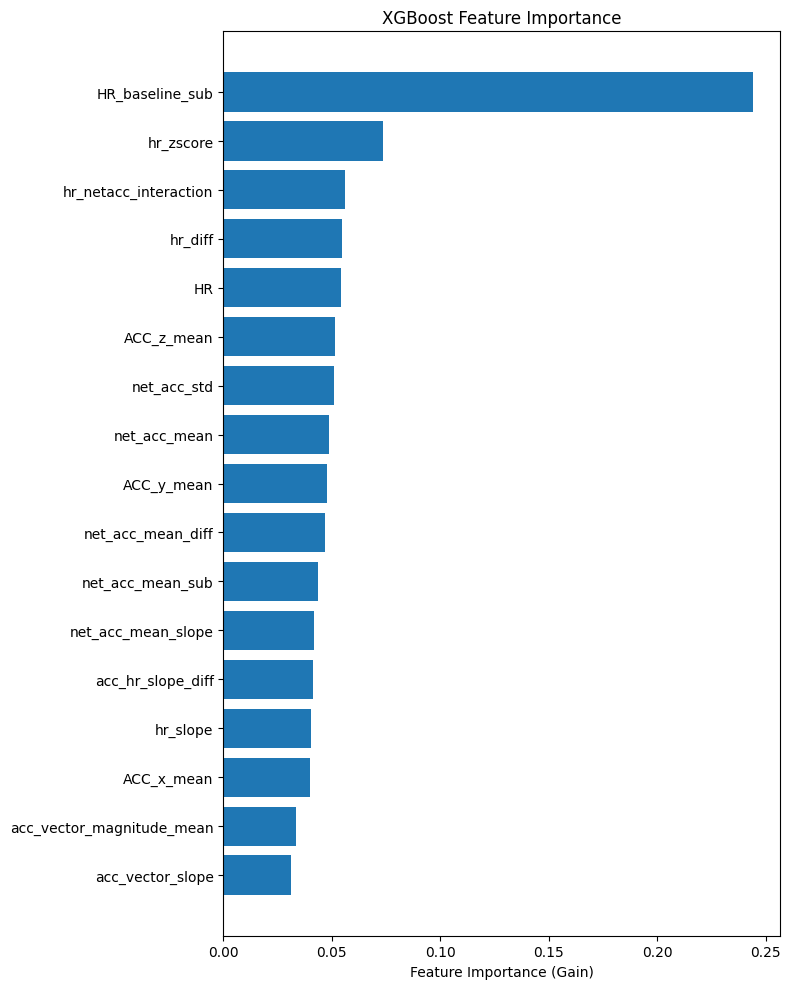

In [16]:
plt.figure(figsize=(8, 10))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [17]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

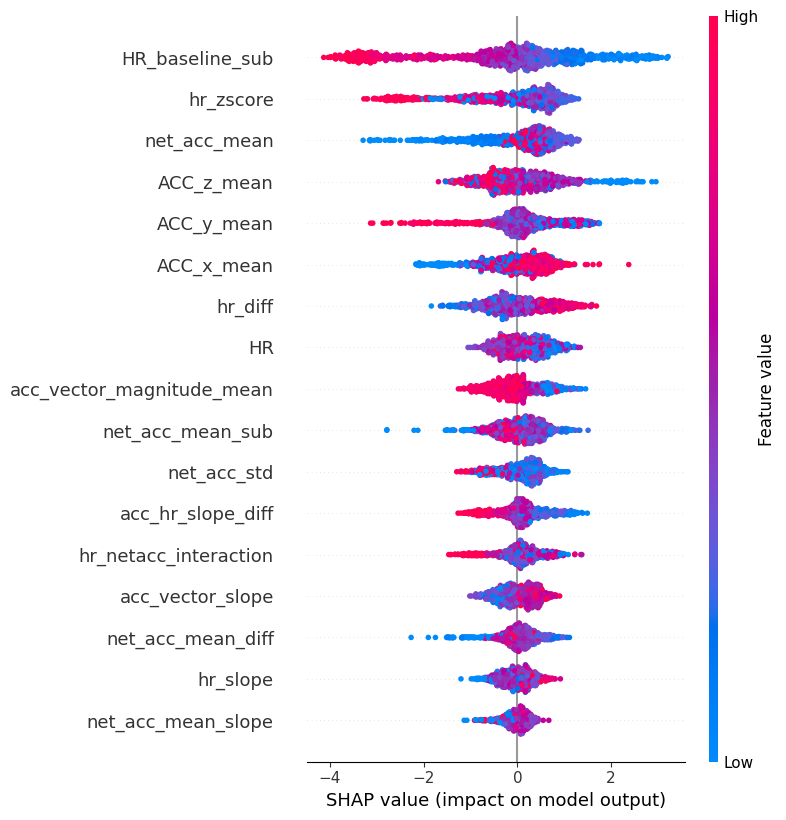

In [18]:
shap.summary_plot(shap_values, X, plot_type="dot")

In [19]:
mean_shap = np.abs(shap_values.values).mean(axis=0)
threshold = 0.003
keep_features = X.columns[mean_shap >= threshold].tolist()
X_pruned = X[keep_features]

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## using X_pruned

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_pruned, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
model = XGBClassifier()

In [33]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [34]:
y_pred = model.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70        96
           1       0.75      0.78      0.76       116

    accuracy                           0.74       212
   macro avg       0.73      0.73      0.73       212
weighted avg       0.74      0.74      0.74       212



## Using regular X

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
model = XGBClassifier()

In [38]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [39]:
y_pred = model.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70        96
           1       0.75      0.78      0.76       116

    accuracy                           0.74       212
   macro avg       0.73      0.73      0.73       212
weighted avg       0.74      0.74      0.74       212

